In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import os

import seaborn as sns
import matplotlib.pyplot as plt

### 绘制热力图

In [14]:
class HeatMapDrawer:
    
    def __init__(self, substance, base):
        '''
        substance:物质名，即该物质文件夹名称。要加'_iteration'或者'_poission'
        base:log的底数
        '''
        file_path = '/'.join([substance, 'features.csv'])
        self.df = pd.read_csv(file_path)
        self.base = base
        self.iso_dic = dict()
        
    
    
    def get_iso_dic(self):
        '''
        读取同位素的二进制字典。
        '''
        iso_dic_pk = './existing_isotopes_dict.pk'
        with open(iso_dic_pk, 'rb') as f:
            self.iso_dic = pkl.load(f)
            
            
            
    def decode(self, emb):
        '''
        将颗粒所属频繁项的embedding转成物质组成式。
        emb_ser:颗粒所属频繁项embedding
        '''
        self.get_iso_dic()
        res = ''
        for k,v in self.iso_dic.items():
            if v==emb&v:
                if not res:
                    res = ''.join([res,k])
                else:
                    res = '-'.join([res,k])
        return res
    
    
    
    def heatmap_data(self):
        '''
        得到绘图需要的数据文件并保存为csv。
        '''
        iso_n = int((self.df.shape[1]-6)/2)
        iso_df = self.df.iloc[:, 1:iso_n+5]
        iso_df = iso_df.drop(['uniq_iso','uniq_iso_n','number'], axis=1)
        iso_df['uniq_iso_emb'] = iso_df['uniq_iso_emb'].astype('int64')
        iso_df['components'] = iso_df['uniq_iso_emb'].apply(lambda x:self.decode(x))
        iso_df = iso_df.iloc[:,1:]

        comp_li = iso_df['components'].unique()
        
        res = pd.DataFrame()
        for comp in comp_li:
            tmp = iso_df.groupby('components').get_group(comp)
            res = pd.concat([res, pd.DataFrame(tmp.count()).T], axis=0)
        res.drop('components', axis=1)
        res = res.replace(0,1)
        res = np.log(res)/np.log(self.base)

        res['components'] = comp_li
        res.to_csv(''.join(['heatmap_', str(self.base), '.csv']), index=None)
        return res
        
        
        
    def draw(self):
        '''
        绘制热力图,需要手动保存。
        '''
        data = self.heatmap_data()
        data.set_index(['components'], inplace=True)
        sns.set_style('whitegrid')
        ax = sns.heatmap(data)
        p = ax.get_figure
        # p.savefig(fig_path, bbox_inches='tight')


In [23]:
drawer.heatmap_data()

,24Mg,27Al,47Ti,51V,52Cr,54Fe,55Mn,59Co,60Ni,63Cu,...,159Tb,163Dy,165Ho,166Er,169Tm,172Yb,175Lu,205Tl,208Pb,components
0,1.968483,2.158362,1.447158,1.544068,1.556303,2.206826,2.222716,1.146128,0.778151,1.612784,...,0.778151,0.30103,0.477121,0.30103,0.0,0.0,0.0,0.000000,2.222716,55Mn-138Ba-140Ce-208Pb
0,1.863323,1.934498,1.278754,1.934498,1.934498,1.934498,1.748188,0.477121,0.301030,0.954243,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.477121,1.792392,27Al-51V-52Cr-54Fe
0,1.602060,1.447158,0.903090,1.602060,0.778151,1.602060,1.602060,0.778151,0.602060,1.000000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,1.602060,24Mg-51V-55Mn-208Pb
0,1.278754,1.230449,0.477121,1.278754,0.000000,1.278754,0.602060,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.602060,24Mg-51V-87Sr-138Ba
0,0.903090,0.845098,0.000000,0.903090,0.000000,0.903090,0.000000,0.000000,0.000000,0.301030,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.903090,24Mg-51V-138Ba-208Pb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000000,0.000000,0.000000,0.000000,0.000000,2.264818,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,2.264818,54Fe-208Pb
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.778151,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,54Fe-87Sr
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.698970,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,54Fe-66Zn
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.602060,0.000000,0.000000,0.000000,0.602060,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,54Fe-63Cu


In [25]:
pd.Series(drawer.df.uniq_iso.unique())

0      {'208Pb', '55Mn', '138Ba', '140Ce'}
1          {'27Al', '51V', '52Cr', '54Fe'}
2         {'55Mn', '51V', '208Pb', '24Mg'}
3         {'87Sr', '51V', '138Ba', '24Mg'}
4        {'138Ba', '51V', '208Pb', '24Mg'}
                      ...                 
152                      {'54Fe', '208Pb'}
153                       {'87Sr', '54Fe'}
154                       {'66Zn', '54Fe'}
155                       {'63Cu', '54Fe'}
156                       {'27Al', '24Mg'}
Length: 157, dtype: object

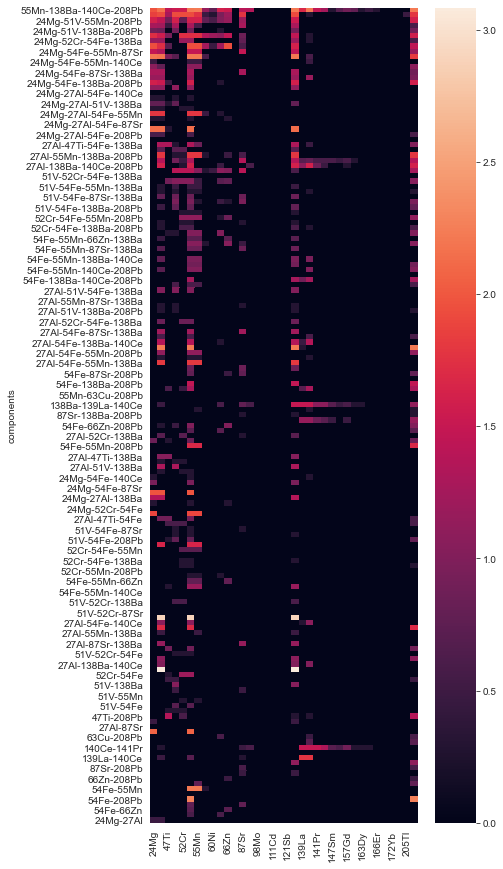

In [17]:
# plt.rcParams["figure.figsize"] = (6, 15)

substance = 'shangturang_iteration'
base = 10

drawer = HeatMapDrawer(substance, base)
drawer.draw()

In [7]:
df = pd.read_csv('shangturang_iteration/features.csv')
df.head(3)

,embedding,uniq_iso,uniq_iso_emb,uniq_iso_n,number,24Mg,27Al,47Ti,51V,52Cr,...,157Gd.1,159Tb.1,163Dy.1,165Ho.1,166Er.1,169Tm.1,172Yb.1,175Lu.1,205Tl.1,208Pb.1
0,34362359906,"{'208Pb', '55Mn', '138Ba', '140Ce'}",3.436236e+10,4.0,835.0,NaN,217.16053,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064505
1,34362359923,"{'208Pb', '55Mn', '138Ba', '140Ce'}",3.436236e+10,4.0,835.0,9.814139,233.18588,NaN,NaN,5.822739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030565
2,34363408448,"{'208Pb', '55Mn', '138Ba', '140Ce'}",3.436236e+10,4.0,835.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215530


In [13]:
df.groupby('uniq_iso').count().embedding

uniq_iso
{'138Ba', '208Pb'}                     13
{'138Ba', '24Mg', '54Fe', '140Ce'}     15
{'138Ba', '24Mg', '54Fe'}               9
{'138Ba', '27Al', '208Pb', '140Ce'}    41
{'138Ba', '27Al', '208Pb', '87Sr'}     23
                                       ..
{'87Sr', '51V', '52Cr'}                 1
{'87Sr', '51V', '54Fe'}                 2
{'87Sr', '51V'}                         3
{'87Sr', '52Cr', '54Fe'}                1
{'87Sr', '54Fe'}                        6
Name: embedding, Length: 157, dtype: int64

In [11]:
pd.Series(df.uniq_iso.unique())

0      {'208Pb', '55Mn', '138Ba', '140Ce'}
1          {'27Al', '51V', '52Cr', '54Fe'}
2         {'55Mn', '51V', '208Pb', '24Mg'}
3         {'87Sr', '51V', '138Ba', '24Mg'}
4        {'138Ba', '51V', '208Pb', '24Mg'}
                      ...                 
152                      {'54Fe', '208Pb'}
153                       {'87Sr', '54Fe'}
154                       {'66Zn', '54Fe'}
155                       {'63Cu', '54Fe'}
156                       {'27Al', '24Mg'}
Length: 157, dtype: object